In [1]:
import time
start = time.time()

import SimpleITK as sitk
import ants
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot images
def plot_image(image, title=None, cmap="gray"):
    plt.imshow(image, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Load the fixed and moving images (replace these with your actual NIfTI paths)
# Read the two images (replace these paths with your actual image paths)
fixed_image = sitk.ReadImage("MICCAI FLARE22/114/artifactFiles/FLARE22Train/images/FLARE22_Tr_0003_0000.nii")  # fixed image
moving_image = sitk.ReadImage("MICCAI FLARE22/114/artifactFiles/FLARE22Train/images/FLARE22_Tr_0031_0000.nii")  # moving image

# Helper function to convert SimpleITK image to ANTs image
def sitk_to_ants(sitk_image):
    # Get the numpy array from SimpleITK image
    np_image = sitk.GetArrayFromImage(sitk_image)
    # Transpose the numpy array because SimpleITK uses (z, y, x) while ANTs uses (x, y, z)
    np_image_transposed = np.transpose(np_image, (2, 1, 0))
    # Create ANTs image with the transposed numpy array
    ants_image = ants.from_numpy(np_image_transposed)
    ants_image.set_spacing(sitk_image.GetSpacing()[::-1])  # Reverse spacing order (x, y, z)
    ants_image.set_origin(sitk_image.GetOrigin()[::-1])    # Reverse origin order (x, y, z)
    ants_image.set_direction(np.array(sitk_image.GetDirection()).reshape(3, 3)[::-1, ::-1])  # Reverse direction
    return ants_image

fixed_image = sitk_to_ants(fixed_image)
moving_image = sitk_to_ants(moving_image)

# Perform affine registration
registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='Affine')

# Extract the registered (warped) image
warped_image = registration['warpedmovout']


In [2]:
fixed_image = fixed_image.numpy()
moving_image = moving_image.numpy()
resampled_moving = warped_image.numpy()

In [3]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from matplotlib.widgets import RectangleSelector
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import copy


class RegistrationPointDataAquisition(object):
    """
    This class provides a GUI for localizing corresponding points in two images, and for evaluating registration results using a linked cursor
    approach, user clicks in one image and the corresponding point is added to the other image.
    """

    def __init__(
        self,
        fixed_image,
        moving_image,
        fixed_window_level=None,
        moving_window_level=None,
        figure_size=(10, 8),
        known_transformation=None,
    ):
        self.fixed_image = fixed_image
        (
            self.fixed_npa,
            self.fixed_min_intensity,
            self.fixed_max_intensity,
        ) = self.get_window_level_numpy_array(self.fixed_image, fixed_window_level)
        self.moving_image = moving_image
        (
            self.moving_npa,
            self.moving_min_intensity,
            self.moving_max_intensity,
        ) = self.get_window_level_numpy_array(self.moving_image, moving_window_level)
        self.fixed_point_indexes = []
        self.moving_point_indexes = []
        self.click_history = (
            []
        )  # Keep a history of user point localizations, enabling undo of last localization.
        self.known_transformation = known_transformation  # If the transformation is valid (not None) then corresponding points are automatically added.
        self.text_and_marker_color = "red"

        ui = self.create_ui()
        display(ui)

        # Create a figure with two axes for the fixed and moving images.
        self.fig, axes = plt.subplots(1, 2, figsize=figure_size)
        # self.fig.canvas.set_window_title('Registration Points Acquisition')
        self.fixed_axes = axes[0]
        self.moving_axes = axes[1]
        # Connect the mouse button press to the canvas (__call__ method is the invoked callback).
        self.fig.canvas.mpl_connect("button_press_event", self)

        # Display the data and the controls, first time we display the images is outside the "update_display" method
        # as that method relies on the previous zoom factor which doesn't exist yet.
        self.fixed_axes.imshow(
            (
                self.fixed_npa[self.fixed_slider.value, :, :]
                if self.fixed_slider
                else self.fixed_npa
            ),
            cmap=plt.cm.Greys_r,
            vmin=self.fixed_min_intensity,
            vmax=self.fixed_max_intensity,
        )
        self.moving_axes.imshow(
            (
                self.moving_npa[self.moving_slider.value, :, :]
                if self.moving_slider
                else self.moving_npa
            ),
            cmap=plt.cm.Greys_r,
            vmin=self.moving_min_intensity,
            vmax=self.moving_max_intensity,
        )
        self.update_display()

    def create_ui(self):
        # Create the active UI components. Height and width are specified in 'em' units. This is
        # a html size specification, size relative to current font size.
        self.viewing_checkbox = widgets.RadioButtons(
            description="Interaction mode:", options=["edit", "view"], value="edit"
        )

        self.clearlast_button = widgets.Button(
            description="Clear Last", width="7em", height="3em"
        )
        self.clearlast_button.on_click(self.clear_last)

        self.clearall_button = widgets.Button(
            description="Clear All", width="7em", height="3em"
        )
        self.clearall_button.on_click(self.clear_all)

        # Sliders are only created if a 3D image, otherwise no need.
        self.fixed_slider = self.moving_slider = None
        if self.fixed_npa.ndim == 3:
            self.fixed_slider = widgets.IntSlider(
                description="fixed image z slice:",
                min=0,
                max=self.fixed_npa.shape[0] - 1,
                step=1,
                value=int((self.fixed_npa.shape[0] - 1) / 2),
                width="20em",
            )
            self.fixed_slider.observe(self.on_slice_slider_value_change, names="value")

            self.moving_slider = widgets.IntSlider(
                description="moving image z slice:",
                min=0,
                max=self.moving_npa.shape[0] - 1,
                step=1,
                value=int((self.moving_npa.shape[0] - 1) / 2),
                width="19em",
            )
            self.moving_slider.observe(self.on_slice_slider_value_change, names="value")

            bx0 = widgets.Box(
                padding=7, children=[self.fixed_slider, self.moving_slider]
            )

        # Layout of UI components. This is pure ugliness because we are not using a UI toolkit. Layout is done
        # using the box widget and padding so that the visible UI components are spaced nicely.
        bx1 = widgets.Box(padding=7, children=[self.viewing_checkbox])
        bx2 = widgets.Box(padding=15, children=[self.clearlast_button])
        bx3 = widgets.Box(padding=15, children=[self.clearall_button])
        return (
            widgets.HBox(children=[widgets.HBox(children=[bx1, bx2, bx3]), bx0])
            if self.fixed_npa.ndim == 3
            else widgets.HBox(children=[widgets.HBox(children=[bx1, bx2, bx3])])
        )

    def get_window_level_numpy_array(self, image, window_level):
        """
        Get the numpy array representation of the image and the min and max of the intensities
        used for display.
        """
        npa = sitk.GetArrayViewFromImage(image)
        if not window_level:
            return npa, npa.min(), npa.max()
        else:
            return (
                npa,
                window_level[1] - window_level[0] / 2.0,
                window_level[1] + window_level[0] / 2.0,
            )

    def on_slice_slider_value_change(self, change):
        self.update_display()

    def update_display(self):
        """
        Display the two images based on the slider values, if relevant, and the points which are on the
        displayed slices.
        """
        # We want to keep the zoom factor which was set prior to display, so we log it before
        # clearing the axes.
        fixed_xlim = self.fixed_axes.get_xlim()
        fixed_ylim = self.fixed_axes.get_ylim()
        moving_xlim = self.moving_axes.get_xlim()
        moving_ylim = self.moving_axes.get_ylim()

        # Draw the fixed image in the first subplot and the localized points.
        self.fixed_axes.clear()
        self.fixed_axes.imshow(
            (
                self.fixed_npa[self.fixed_slider.value, :, :]
                if self.fixed_slider
                else self.fixed_npa
            ),
            cmap=plt.cm.Greys_r,
            vmin=self.fixed_min_intensity,
            vmax=self.fixed_max_intensity,
        )
        # Positioning the text is a bit tricky, we position relative to the data coordinate system, but we
        # want to specify the shift in pixels as we are dealing with display. We therefore (a) get the data
        # point in the display coordinate system in pixel units (b) modify the point using pixel offset and
        # transform back to the data coordinate system for display.
        text_x_offset = -10
        text_y_offset = -10
        for i, pnt in enumerate(self.fixed_point_indexes):
            if (
                self.fixed_slider and int(pnt[2] + 0.5) == self.fixed_slider.value
            ) or not self.fixed_slider:
                self.fixed_axes.scatter(
                    pnt[0], pnt[1], s=90, marker="+", color=self.text_and_marker_color
                )
                # Get point in pixels.
                text_in_data_coords = self.fixed_axes.transData.transform(
                    [pnt[0], pnt[1]]
                )
                # Offset in pixels and get in data coordinates.
                text_in_data_coords = self.fixed_axes.transData.inverted().transform(
                    (
                        text_in_data_coords[0] + text_x_offset,
                        text_in_data_coords[1] + text_y_offset,
                    )
                )
                self.fixed_axes.text(
                    text_in_data_coords[0],
                    text_in_data_coords[1],
                    str(i),
                    color=self.text_and_marker_color,
                )
        self.fixed_axes.set_title(
            f"fixed image - localized {len(self.fixed_point_indexes)} points"
        )
        self.fixed_axes.set_axis_off()

        # Draw the moving image in the second subplot and the localized points.
        self.moving_axes.clear()
        self.moving_axes.imshow(
            (
                self.moving_npa[self.moving_slider.value, :, :]
                if self.moving_slider
                else self.moving_npa
            ),
            cmap=plt.cm.Greys_r,
            vmin=self.moving_min_intensity,
            vmax=self.moving_max_intensity,
        )
        for i, pnt in enumerate(self.moving_point_indexes):
            if (
                self.moving_slider and int(pnt[2] + 0.5) == self.moving_slider.value
            ) or not self.moving_slider:
                self.moving_axes.scatter(
                    pnt[0], pnt[1], s=90, marker="+", color=self.text_and_marker_color
                )
                text_in_data_coords = self.moving_axes.transData.transform(
                    [pnt[0], pnt[1]]
                )
                text_in_data_coords = self.moving_axes.transData.inverted().transform(
                    (
                        text_in_data_coords[0] + text_x_offset,
                        text_in_data_coords[1] + text_y_offset,
                    )
                )
                self.moving_axes.text(
                    text_in_data_coords[0],
                    text_in_data_coords[1],
                    str(i),
                    color=self.text_and_marker_color,
                )
        self.moving_axes.set_title(
            f"moving image - localized {len(self.moving_point_indexes)} points"
        )
        self.moving_axes.set_axis_off()

        # Set the zoom factor back to what it was before we cleared the axes, and rendered our data.
        self.fixed_axes.set_xlim(fixed_xlim)
        self.fixed_axes.set_ylim(fixed_ylim)
        self.moving_axes.set_xlim(moving_xlim)
        self.moving_axes.set_ylim(moving_ylim)

        self.fig.canvas.draw_idle()

    def clear_all(self, button):
        """
        Get rid of all the data.
        """
        del self.fixed_point_indexes[:]
        del self.moving_point_indexes[:]
        del self.click_history[:]
        self.update_display()

    def clear_last(self, button):
        """
        Remove last point or point-pair addition (depends on whether the interface is used for localizing point pairs or
        evaluation of registration).
        """
        if self.click_history:
            if self.known_transformation:
                self.click_history.pop().pop()
            self.click_history.pop().pop()
            self.update_display()

    def get_points(self):
        """
        Get the points in the image coordinate systems.
        """
        if len(self.fixed_point_indexes) != len(self.moving_point_indexes):
            raise Exception(
                "Number of localized points in fixed and moving images does not match."
            )
        fixed_point_list = [
            self.fixed_image.TransformContinuousIndexToPhysicalPoint(pnt)
            for pnt in self.fixed_point_indexes
        ]
        moving_point_list = [
            self.moving_image.TransformContinuousIndexToPhysicalPoint(pnt)
            for pnt in self.moving_point_indexes
        ]
        return fixed_point_list, moving_point_list

    def __call__(self, event):
        """
        Callback invoked when the user clicks inside the figure.
        """
        # We add points only in 'edit' mode. If the spatial transformation between the two images is known, self.known_transformation was set,
        # then every button_press_event will generate a point in each of the images. Finally, we enforce that all points have a corresponding
        # point in the other image by not allowing the user to add multiple points in the same image, they have to add points by switching between
        # the two images.
        if self.viewing_checkbox.value == "edit":
            if event.inaxes == self.fixed_axes:
                if len(self.fixed_point_indexes) - len(self.moving_point_indexes) <= 0:
                    self.fixed_point_indexes.append(
                        (event.xdata, event.ydata, self.fixed_slider.value)
                        if self.fixed_slider
                        else (event.xdata, event.ydata)
                    )
                    self.click_history.append(self.fixed_point_indexes)
                    if self.known_transformation:
                        moving_point_physical = self.known_transformation.TransformPoint(
                            self.fixed_image.TransformContinuousIndexToPhysicalPoint(
                                self.fixed_point_indexes[-1]
                            )
                        )
                        moving_point_indexes = (
                            self.moving_image.TransformPhysicalPointToContinuousIndex(
                                moving_point_physical
                            )
                        )
                        self.moving_point_indexes.append(moving_point_indexes)
                        self.click_history.append(self.moving_point_indexes)
                        if self.moving_slider:
                            z_index = int(moving_point_indexes[2] + 0.5)
                            if (
                                self.moving_slider.max >= z_index
                                and self.moving_slider.min <= z_index
                            ):
                                self.moving_slider.value = z_index
                    self.update_display()
            if event.inaxes == self.moving_axes:
                if len(self.moving_point_indexes) - len(self.fixed_point_indexes) <= 0:
                    self.moving_point_indexes.append(
                        (event.xdata, event.ydata, self.moving_slider.value)
                        if self.moving_slider
                        else (event.xdata, event.ydata)
                    )
                    self.click_history.append(self.moving_point_indexes)
                    if self.known_transformation:
                        inverse_transform = self.known_transformation.GetInverse()
                        fixed_point_physical = inverse_transform.TransformPoint(
                            self.moving_image.TransformContinuousIndexToPhysicalPoint(
                                self.moving_point_indexes[-1]
                            )
                        )
                        fixed_point_indexes = (
                            self.fixed_image.TransformPhysicalPointToContinuousIndex(
                                fixed_point_physical
                            )
                        )
                        self.fixed_point_indexes.append(fixed_point_indexes)
                        self.click_history.append(self.fixed_point_indexes)
                        if self.fixed_slider:
                            z_index = int(fixed_point_indexes[2] + 0.5)
                            if (
                                self.fixed_slider.max >= z_index
                                and self.fixed_slider.min <= z_index
                            ):
                                self.fixed_slider.value = z_index
                    self.update_display()


class PointDataAquisition(object):
    def __init__(self, image, window_level=None, figure_size=(10, 8)):
        self.image = image
        (
            self.npa,
            self.min_intensity,
            self.max_intensity,
        ) = self.get_window_level_numpy_array(self.image, window_level)
        self.point_indexes = []

        ui = self.create_ui()
        display(ui)

        # Create a figure.
        self.fig, self.axes = plt.subplots(1, 1, figsize=figure_size)
        # Connect the mouse button press to the canvas (__call__ method is the invoked callback).
        self.fig.canvas.mpl_connect("button_press_event", self)

        # Display the data and the controls, first time we display the image is outside the "update_display" method
        # as that method relies on the previous zoom factor which doesn't exist yet.
        self.axes.imshow(
            self.npa[self.slice_slider.value, :, :] if self.slice_slider else self.npa,
            cmap=plt.cm.Greys_r,
            vmin=self.min_intensity,
            vmax=self.max_intensity,
        )
        self.update_display()

    def create_ui(self):
        # Create the active UI components. Height and width are specified in 'em' units. This is
        # a html size specification, size relative to current font size.
        self.viewing_checkbox = widgets.RadioButtons(
            description="Interaction mode:", options=["edit", "view"], value="edit"
        )

        self.clearlast_button = widgets.Button(
            description="Clear Last", width="7em", height="3em"
        )
        self.clearlast_button.on_click(self.clear_last)

        self.clearall_button = widgets.Button(
            description="Clear All", width="7em", height="3em"
        )
        self.clearall_button.on_click(self.clear_all)

        # Slider is only created if a 3D image, otherwise no need.
        self.slice_slider = None
        if self.npa.ndim == 3:
            self.slice_slider = widgets.IntSlider(
                description="image z slice:",
                min=0,
                max=self.npa.shape[0] - 1,
                step=1,
                value=int((self.npa.shape[0] - 1) / 2),
                width="20em",
            )
            self.slice_slider.observe(self.on_slice_slider_value_change, names="value")
            bx0 = widgets.Box(padding=7, children=[self.slice_slider])

        # Layout of UI components. This is pure ugliness because we are not using a UI toolkit. Layout is done
        # using the box widget and padding so that the visible UI components are spaced nicely.
        bx1 = widgets.Box(padding=7, children=[self.viewing_checkbox])
        bx2 = widgets.Box(padding=15, children=[self.clearlast_button])
        bx3 = widgets.Box(padding=15, children=[self.clearall_button])
        return (
            widgets.HBox(children=[widgets.HBox(children=[bx1, bx2, bx3]), bx0])
            if self.slice_slider
            else widgets.HBox(children=[widgets.HBox(children=[bx1, bx2, bx3])])
        )

    def get_window_level_numpy_array(self, image, window_level):
        npa = sitk.GetArrayViewFromImage(image)
        if not window_level:
            return npa, npa.min(), npa.max()
        else:
            return (
                npa,
                window_level[1] - window_level[0] / 2.0,
                window_level[1] + window_level[0] / 2.0,
            )

    def on_slice_slider_value_change(self, change):
        self.update_display()

    def update_display(self):
        # We want to keep the zoom factor which was set prior to display, so we log it before
        # clearing the axes.
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()

        # Draw the image and localized points.
        self.axes.clear()
        self.axes.imshow(
            self.npa[self.slice_slider.value, :, :] if self.slice_slider else self.npa,
            cmap=plt.cm.Greys_r,
            vmin=self.min_intensity,
            vmax=self.max_intensity,
        )
        # Positioning the text is a bit tricky, we position relative to the data coordinate system, but we
        # want to specify the shift in pixels as we are dealing with display. We therefore (a) get the data
        # point in the display coordinate system in pixel units (b) modify the point using pixel offset and
        # transform back to the data coordinate system for display.
        text_x_offset = -10
        text_y_offset = -10
        for i, pnt in enumerate(self.point_indexes):
            if (
                self.slice_slider and int(pnt[2] + 0.5) == self.slice_slider.value
            ) or not self.slice_slider:
                self.axes.scatter(pnt[0], pnt[1], s=90, marker="+", color="yellow")
                # Get point in pixels.
                text_in_data_coords = self.axes.transData.transform([pnt[0], pnt[1]])
                # Offset in pixels and get in data coordinates.
                text_in_data_coords = self.axes.transData.inverted().transform(
                    (
                        text_in_data_coords[0] + text_x_offset,
                        text_in_data_coords[1] + text_y_offset,
                    )
                )
                self.axes.text(
                    text_in_data_coords[0],
                    text_in_data_coords[1],
                    str(i),
                    color="yellow",
                )
        self.axes.set_title(f"localized {len(self.point_indexes)} points")
        self.axes.set_axis_off()

        # Set the zoom factor back to what it was before we cleared the axes, and rendered our data.
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)

        self.fig.canvas.draw_idle()

    def add_point_indexes(self, point_index_data):
        self.validate_points(point_index_data)
        self.point_indexes.append(list(point_index_data))
        self.update_display()

    def set_point_indexes(self, point_index_data):
        self.validate_points(point_index_data)
        del self.point_indexes[:]
        self.point_indexes = list(point_index_data)
        self.update_display()

    def validate_points(self, point_index_data):
        for p in point_index_data:
            if self.npa.ndim != len(p):
                raise ValueError(
                    "Given point ("
                    + ", ".join(map(str, p))
                    + ") dimension does not match image dimension."
                )
            outside_2d_bounds = (
                p[0] >= self.npa.shape[2]
                or p[0] < 0
                or p[1] >= self.npa.shape[1]
                or p[1] < 0
            )
            outside_bounds = outside_2d_bounds or (
                False if self.npa.ndim == 2 else p[2] >= self.npa.shape[0] or p[2] < 0
            )
            if outside_bounds:
                raise ValueError(
                    "Given point ("
                    + ", ".join(map(str, p))
                    + ") is outside the image bounds."
                )

    def clear_all(self, button):
        del self.point_indexes[:]
        self.update_display()

    def clear_last(self, button):
        if self.point_indexes:
            self.point_indexes.pop()
            self.update_display()

    def get_points(self):
        return [
            self.image.TransformContinuousIndexToPhysicalPoint(pnt)
            for pnt in self.point_indexes
        ]

    def get_point_indexes(self):
        """
        Return the point indexes, not the continous index we keep.
        """
        # Round and then cast to int, just rounding will return a float
        return [tuple(map(lambda x: int(round(x)), pnt)) for pnt in self.point_indexes]

    def __call__(self, event):
        if self.viewing_checkbox.value == "edit":
            if event.inaxes == self.axes:
                self.point_indexes.append(
                    (event.xdata, event.ydata, self.slice_slider.value)
                    if self.slice_slider
                    else (event.xdata, event.ydata)
                )
                self.update_display()


def multi_image_display2D(
    image_list,
    title_list=None,
    window_level_list=None,
    figure_size=(10, 8),
    horizontal=True,
):
    if title_list:
        if len(image_list) != len(title_list):
            raise ValueError("Title list and image list lengths do not match")
    else:
        title_list = [""] * len(image_list)

    # Create a figure.
    col_num, row_num = (len(image_list), 1) if horizontal else (1, len(image_list))
    fig, axes = plt.subplots(row_num, col_num, figsize=figure_size)
    if len(image_list) == 1:
        axes = [axes]

    # Get images as numpy arrays for display and the window level settings
    npa_list = list(map(sitk.GetArrayViewFromImage, image_list))
    if not window_level_list:
        min_intensity_list = list(map(np.min, npa_list))
        max_intensity_list = list(map(np.max, npa_list))
    else:
        min_intensity_list = list(map(lambda x: x[1] - x[0] / 2.0, window_level_list))
        max_intensity_list = list(map(lambda x: x[1] + x[0] / 2.0, window_level_list))

    # Draw the image(s)
    for ax, npa, title, min_intensity, max_intensity in zip(
        axes, npa_list, title_list, min_intensity_list, max_intensity_list
    ):
        ax.imshow(npa, cmap=plt.cm.Greys_r, vmin=min_intensity, vmax=max_intensity)
        ax.set_title(title)
        ax.set_axis_off()
    fig.tight_layout()
    return (fig, axes)


class MultiImageDisplay(object):
    """
    This class provides a GUI for displaying 3D images. It supports display of
    multiple images in the same UI. The image slices are selected according to
    the axis specified by the user. Each image can have a title and a slider to
    scroll through the stack. The images can also share a single slider if they
    have the same number of slices along the given axis. Images are either
    grayscale or color. The intensity range used for display (window-level) can
    be specified by the user as input to the constructor or set via the displayed
    slider. For color images the intensity control slider will be disabled. This
    allows us to display both color and grayscale images in the same figure with
    a consistent look to the controls. The range of the intensity slider is set
    to be from top/bottom 2% of intensities (accommodating for outliers). Images
    are displayed either in horizontal or vertical layout, depending on the
    users choice.
    """

    def __init__(
        self,
        image_list,
        axis=0,
        shared_slider=False,
        title_list=None,
        window_level_list=None,
        intensity_slider_range_percentile=[2, 98],
        figure_size=(10, 8),
        horizontal=True,
    ):
        self.npa_list, wl_range, wl_init = self.get_window_level_numpy_array(
            image_list, window_level_list, intensity_slider_range_percentile
        )
        if title_list:
            if len(image_list) != len(title_list):
                raise ValueError("Title list and image list lengths do not match")
            self.title_list = list(title_list)
        else:
            self.title_list = [""] * len(image_list)

        # Our dynamic slice, based on the axis the user specifies
        self.slc = [slice(None)] * 3
        self.axis = axis

        ui = self.create_ui(shared_slider, wl_range, wl_init)
        display(ui)

        # Create a figure.
        col_num, row_num = (len(image_list), 1) if horizontal else (1, len(image_list))
        self.fig, self.axes = plt.subplots(row_num, col_num, figsize=figure_size)
        if len(image_list) == 1:
            self.axes = [self.axes]

        # Display the data and the controls, first time we display the image is outside the "update_display" method
        # as that method relies on the previous zoom factor which doesn't exist yet.
        for ax, npa, slider, wl_slider in zip(
            self.axes, self.npa_list, self.slider_list, self.wl_list
        ):
            self.slc[self.axis] = slice(slider.value, slider.value + 1)
            # Need to use squeeze to collapse degenerate dimension (e.g. RGB image size 124 124 1 3)
            ax.imshow(
                np.squeeze(npa[tuple(self.slc)]),
                cmap=plt.cm.Greys_r,
                vmin=wl_slider.value[0],
                vmax=wl_slider.value[1],
            )
        self.update_display()
        plt.tight_layout()

    def create_ui(self, shared_slider, wl_range, wl_init):
        # Create the active UI components. Height and width are specified in 'em' units. This is
        # a html size specification, size relative to current font size.

        if shared_slider:
            # Validate that all the images have the same size along the axis which we scroll through
            sz = self.npa_list[0].shape[self.axis]
            for npa in self.npa_list:
                if npa.shape[self.axis] != sz:
                    raise ValueError(
                        "Not all images have the same size along the specified axis, cannot share slider."
                    )

            slider = widgets.IntSlider(
                description="image slice:",
                min=0,
                max=sz - 1,
                step=1,
                value=int((sz - 1) / 2),
                width="20em",
            )
            slider.observe(self.on_slice_slider_value_change, names="value")
            self.slider_list = [slider] * len(self.npa_list)
            slicer_box = widgets.Box(padding=7, children=[slider])
        else:
            self.slider_list = []
            for npa in self.npa_list:
                slider = widgets.IntSlider(
                    description="image slice:",
                    min=0,
                    max=npa.shape[self.axis] - 1,
                    step=1,
                    value=int((npa.shape[self.axis] - 1) / 2),
                    width="20em",
                )
                slider.observe(self.on_slice_slider_value_change, names="value")
                self.slider_list.append(slider)
            slicer_box = widgets.Box(padding=7, children=self.slider_list)
        self.wl_list = []
        # Each image has a window-level slider, but it is disabled if the image
        # is a color image len(npa.shape)==4 . This allows us to display both
        # color and grayscale images in the same UI while retaining a reasonable
        # layout for the sliders.
        for r_values, i_values, npa in zip(wl_range, wl_init, self.npa_list):
            wl_range_slider = widgets.IntRangeSlider(
                description="intensity:",
                min=r_values[0],
                max=r_values[1],
                step=1,
                value=[i_values[0], i_values[1]],
                width="20em",
                disabled=len(npa.shape) == 4,
            )
            wl_range_slider.observe(self.on_wl_slider_value_change, names="value")
            self.wl_list.append(wl_range_slider)
        wl_box = widgets.Box(padding=7, children=self.wl_list)
        return widgets.VBox(children=[slicer_box, wl_box])

    def get_window_level_numpy_array(
        self, image_list, window_level_list, intensity_slider_range_percentile
    ):
        # Using GetArray and not GetArrayView because we don't keep references
        # to the original images. If they are deleted outside the view would become
        # invalid, so we use a copy which guarantees that the GUI is consistent.
        npa_list = list(map(sitk.GetArrayFromImage, image_list))

        wl_range = []
        wl_init = []
        # We need to iterate over the images because they can be a mix of
        # grayscale and color images. If they are color we set the wl_range
        # to [0,255] and the wl_init is equal, ignoring the window_level_list
        # entry.
        for i, npa in enumerate(npa_list):
            if len(npa.shape) == 4:  # color image
                wl_range.append((0, 255))
                wl_init.append((0, 255))
                # ignore any window_level_list entry
            else:
                # We don't necessarily take the minimum/maximum values, just in case there are outliers
                # user can specify how much to take off from top and bottom.
                min_max = np.percentile(
                    npa.flatten(), intensity_slider_range_percentile
                )
                wl_range.append((min_max[0], min_max[1]))
                if not window_level_list:  # No list was given.
                    wl_init.append(wl_range[-1])
                else:
                    wl = window_level_list[i]
                    if wl:
                        wl_init.append((wl[1] - wl[0] / 2.0, wl[1] + wl[0] / 2.0))
                    else:  # We have a list, but for this image the entry was left empty: []
                        wl_init.append(wl_range[-1])
        return (npa_list, wl_range, wl_init)

    def on_slice_slider_value_change(self, change):
        self.update_display()

    def on_wl_slider_value_change(self, change):
        self.update_display()

    def update_display(self):
        # Draw the image(s)
        for ax, npa, title, slider, wl_slider in zip(
            self.axes, self.npa_list, self.title_list, self.slider_list, self.wl_list
        ):
            # We want to keep the zoom factor which was set prior to display, so we log it before
            # clearing the axes.
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()

            self.slc[self.axis] = slice(slider.value, slider.value + 1)
            ax.clear()
            # Need to use squeeze to collapse degenerate dimension (e.g. RGB image size 124 124 1 3)
            ax.imshow(
                np.squeeze(npa[tuple(self.slc)]),
                cmap=plt.cm.Greys_r,
                vmin=wl_slider.value[0],
                vmax=wl_slider.value[1],
            )
            ax.set_title(title)
            ax.set_axis_off()

            # Set the zoom factor back to what it was before we cleared the axes, and rendered our data.
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

        self.fig.canvas.draw_idle()


class ROIDataAquisition(object):
    """
    This class provides a GUI for selecting box shaped Regions Of Interest (ROIs). Each ROI is represented as a
    tuple: ((min_x,max_x),(min_y,max_y), and possibly (min_z,max_z)) if dealing with a 3D image.
    When using the zoom/pan tool from the toolbar ROI selection is disabled. Once you click again on the zoom/pan
    button zooming/panning will be disabled and ROI selection is enabled.
    Note that when you are marking the ROI on a slice that is outside the Z-range selected by the
    range slider, once you are done selecting the ROI, you will see no change on the current slice. This is the
    correct behavior, though initially you may be surprised by it.
    """

    def __init__(self, image, window_level=None, figure_size=(10, 8)):
        self.image = image
        (
            self.npa,
            self.min_intensity,
            self.max_intensity,
        ) = self.get_window_level_numpy_array(self.image, window_level)
        self.rois = []

        # ROI display settings
        self.roi_display_properties = dict(
            facecolor="red", edgecolor="black", alpha=0.2, fill=True
        )

        ui = self.create_ui()
        display(ui)

        # Create a figure.
        self.fig, self.axes = plt.subplots(1, 1, figsize=figure_size)
        # Connect the mouse button press to the canvas (__call__ method is the invoked callback).
        self.fig.canvas.mpl_connect("button_press_event", self)
        self.roi_selector = RectangleSelector(
            self.axes,
            lambda eclick, erelease: None,
            useblit=True,
            button=[1, 3],  # Left, right buttons only.
            minspanx=5,
            minspany=5,  # Ignore motion smaller than 5 pixels.
            spancoords="pixels",
            interactive=True,
            props=self.roi_display_properties,
        )
        self.roi_selector.set_visible(False)

        # Display the data and the controls, first time we display the image is outside the "update_display" method
        # as that method relies on the existence of a previous image which is removed from the figure.
        self.axes.imshow(
            self.npa[self.slice_slider.value, :, :] if self.slice_slider else self.npa,
            cmap=plt.cm.Greys_r,
            vmin=self.min_intensity,
            vmax=self.max_intensity,
        )
        self.update_display()

    def create_ui(self):
        # Create the active UI components. Height and width are specified in 'em' units. This is
        # a html size specification, size relative to current font size.
        self.addroi_button = widgets.Button(
            description="Add ROI", width="7em", height="3em"
        )
        self.addroi_button.on_click(self.add_roi)
        self.clearlast_button = widgets.Button(
            description="Clear Last", width="7em", height="3em"
        )
        self.clearlast_button.on_click(self.clear_last)

        self.clearall_button = widgets.Button(
            description="Clear All", width="7em", height="3em"
        )
        self.clearall_button.on_click(self.clear_all)

        # Create sliders only if 3D image
        self.slice_slider = self.roi_range_slider = None
        if self.npa.ndim == 3:
            self.roi_range_slider = widgets.IntRangeSlider(
                description="ROI z range:",
                min=0,
                max=self.npa.shape[0] - 1,
                step=1,
                value=[0, self.npa.shape[0] - 1],
                width="20em",
            )
            bx4 = widgets.Box(padding=15, children=[self.roi_range_slider])
            self.slice_slider = widgets.IntSlider(
                description="image z slice:",
                min=0,
                max=self.npa.shape[0] - 1,
                step=1,
                value=int((self.npa.shape[0] - 1) / 2),
                width="20em",
            )
            self.slice_slider.observe(self.on_slice_slider_value_change, names="value")
            bx0 = widgets.Box(padding=7, children=[self.slice_slider])

        # Layout of UI components. This is pure ugliness because we are not using a UI toolkit. Layout is done
        # using the box widget and padding so that the visible UI components are spaced nicely.
        bx1 = widgets.Box(padding=7, children=[self.addroi_button])
        bx2 = widgets.Box(padding=15, children=[self.clearlast_button])
        bx3 = widgets.Box(padding=15, children=[self.clearall_button])
        return (
            widgets.HBox(
                children=[
                    widgets.HBox(children=[bx1, bx2, bx3]),
                    widgets.VBox(children=[bx0, bx4]),
                ]
            )
            if self.npa.ndim == 3
            else widgets.HBox(children=[widgets.HBox(children=[bx1, bx2, bx3])])
        )

    def on_slice_slider_value_change(self, change):
        self.update_display()

    def get_window_level_numpy_array(self, image, window_level):
        npa = sitk.GetArrayViewFromImage(image)
        # We don't take the minimum/maximum values, just in case there are outliers (top/bottom 2%)
        if not window_level:
            min_max = np.percentile(npa.flatten(), [2, 98])
            return npa, min_max[0], min_max[1]
        else:
            return (
                npa,
                window_level[1] - window_level[0] / 2.0,
                window_level[1] + window_level[0] / 2.0,
            )

    def update_display(self):
        # Draw the image and ROIs.
        # imshow adds an image to the axes, so we also remove the previous one.
        self.axes.imshow(
            self.npa[self.slice_slider.value, :, :] if self.slice_slider else self.npa,
            cmap=plt.cm.Greys_r,
            vmin=self.min_intensity,
            vmax=self.max_intensity,
        )
        self.axes.images[0].remove()
        # Iterate over all of the ROIs and only display/undisplay those that are relevant.
        if self.slice_slider:
            for roi_data in self.rois:
                if (
                    self.slice_slider.value >= roi_data[3][0]
                    and self.slice_slider.value <= roi_data[3][1]
                ):
                    roi_data[0].set_visible(True)
                else:
                    roi_data[0].set_visible(False)
        self.axes.set_title(f"selected {len(self.rois)} ROIs")
        self.axes.set_axis_off()

        self.fig.canvas.draw_idle()

    def add_roi_data(self, roi_data):
        """
        Add regions of interest to this GUI.
        Input is an iterable containing tuples where each tuple contains
        either two or three tuples (min_x,max_x),(min_y,max_y), (min_z,max_z).
        depending on the image dimensionality. The ROI
        is the box defined by these integer values and includes
        both min/max values.
        """
        self.validate_rois(roi_data)

        for roi in roi_data:
            self.rois.append(
                (
                    patches.Rectangle(
                        (roi[0][0], roi[1][0]),
                        roi[0][1] - roi[0][0],
                        roi[1][1] - roi[1][0],
                        **self.roi_display_properties,
                    ),
                    roi[0],
                    roi[1],
                    roi[2] if self.npa.ndim == 3 else None,
                )
            )
            self.axes.add_patch(self.rois[-1][0])
        self.update_display()

    def set_rois(self, roi_data):
        """
        Clear any existing ROIs and set the display to the given ones.
        Input is an iterable containing tuples where each tuple contains
        two or three tuples (min_x,max_x),(min_y,max_y), (min_z,max_z) depending
        on the image dimensionality. The ROI
        is the box defined by these integer values and includes
        both min/max values.
        """
        self.clear_all_data()
        self.add_roi_data(roi_data)

    def validate_rois(self, roi_data):
        for roi in roi_data:
            for i, bounds in enumerate(roi, 1):
                if bounds[0] > bounds[1]:
                    raise ValueError(
                        "First element in each tuple is expected to be smaller than second element, error in ROI ("
                        + ", ".join(map(str, roi))
                        + ")."
                    )
                # Note that SimpleITK uses x-y-z specification vs. numpy's z-y-x
                if not (
                    bounds[0] >= 0 and bounds[1] < self.npa.shape[self.npa.ndim - i]
                ):
                    raise ValueError(
                        "Given ROI ("
                        + ", ".join(map(str, roi))
                        + ") is outside the image bounds."
                    )

    def add_roi(self, button):
        if self.roi_selector.visible:
            self.roi_selector.set_visible(False)
            # Extent is in sub-pixel coordinates, we need it in pixels/voxels.
            roi_extent = [int(round(coord)) for coord in self.roi_selector.extents]
            # We keep the patch for display and the x,y,z ranges of the ROI.
            self.rois.append(
                (
                    patches.Rectangle(
                        (roi_extent[0], roi_extent[2]),
                        roi_extent[1] - roi_extent[0],
                        roi_extent[3] - roi_extent[2],
                        **self.roi_display_properties,
                    ),
                    (roi_extent[0], roi_extent[1]),
                    (roi_extent[2], roi_extent[3]),
                    self.roi_range_slider.value if self.roi_range_slider else None,
                )
            )
            self.axes.add_patch(self.rois[-1][0])
            self.update_display()

    def clear_all_data(self):
        for roi_data in self.rois:
            roi_data[0].remove()
        del self.rois[:]

    def clear_all(self, button):
        self.clear_all_data()
        self.update_display()

    def clear_last(self, button):
        if self.rois:
            self.rois[-1][0].remove()
            self.rois.pop()
            self.update_display()

    def get_rois(self):
        """
        Return a list of tuples representing the ROIs. Each tuple contains either two or three tuples (min_x,max_x),
        (min_y,max_y), (min_z,max_z) depending on image dimensionality. The ROI is the box defined by these integer values and includes
        both min/max values.
        """
        return [
            (
                (roi_data[1], roi_data[2], roi_data[3])
                if self.npa.ndim == 3
                else (roi_data[1], roi_data[2])
            )
            for roi_data in self.rois
        ]

    def __call__(self, event):
        # When Zoom or pan are active we will
        # ignore the button press, once the user deactivates the zoom/pan we can allow them
        # to select the ROI.
        # Details in this stack overflow discussion:
        # http://stackoverflow.com/questions/20711148/ignore-matplotlib-cursor-widget-when-toolbar-widget-selected
        if self.fig.canvas.manager.toolbar.mode == "":
            self.roi_selector.set_visible(True)
            self.addroi_button.disabled = False
            self.update_display()


class PairedPointDataManipulation(object):
    """
    This class provides a GUI for paired point creation, to illustrate the use of the
    SimpleITK LandmarkBasedTransformInitializer. The GUI displays a region of size
    [0,data_scale]X[0,data_scale] in which the user can select points. The user can
    then translate and rotate the point configuration. The points are either fiducials
    (used in registration) or targets (not used in registration). The transformation
    estimated by the component can be either rigid or affine.
    The UI allows the user to add noise, bias,... to the moving fiducials and perform
    registration.
    """

    def __init__(
        self, transform=sitk.Euler2DTransform(), data_scale=100.0, figure_size=(8, 6)
    ):
        self.figure_size = figure_size

        # Properties of the glyphs used to display the fixed/moving fiducials/targets and rotation centroid.
        self.FIXED_FIDUCIAL_CONFIG = {
            "marker": "x",
            "markersize": 6,
            "color": "#ff8888",
        }
        self.FIXED_TARGET_CONFIG = {
            "marker": "s",
            "markerfacecolor": "none",
            "markersize": 6,
            "color": "#88ff88",
        }
        self.MOVING_FIDUCIAL_CONFIG = {
            "marker": "+",
            "markersize": 8,
            "color": "#ffdddd",
        }
        self.MOVING_TARGET_CONFIG = {
            "marker": "o",
            "markerfacecolor": "none",
            "markersize": 8,
            "color": "#ddffdd",
        }
        self.CENTROID_CONFIG = {"marker": ".", "markersize": 4, "color": "#58d8ff"}

        # The fixed fiducials/targets do not have noise added to them.
        self.fixed_fiducials = []
        self.fixed_targets = []
        # The moving fiducials will have noise, bias added to their coordinates. Noise
        # model is zero mean Gaussian, isotropic and homogeneous.
        self.moving_fiducials = []
        self.moving_targets = []
        # This list will contain the FLE vectors, not the FLE. Allows us to
        # accumulate the error as the user adds errors multiple times.
        self.FLE = []
        # Centroid of the moving fiducials and targets.
        self.centroid = []

        # Fiducials can only be added before any noise/bias is added to the existing fiducials
        self.can_add_fiducials = True

        # The transformation type that will be used by the LandmarkBasedTransformInitializer
        # this component supports, Rigid2DTransform, AffineTransform, BSplineTransform
        self.transform = transform

        # The point data will be in [0,data_scale]x[0,data_scale]
        self.scale = data_scale

        self.ui = self.create_ui()
        display(self.ui)

        # Create a figure.
        self.fig, self.axes = plt.subplots(
            nrows=1, ncols=1, sharex=True, sharey=True, figsize=self.figure_size
        )

        self.fig.canvas.mpl_connect("button_press_event", self.on_press)
        self.fig.canvas.mpl_connect("motion_notify_event", self.on_motion)
        self.fig.canvas.mpl_connect("button_release_event", self.on_release)

        self.update_display()

    def create_ui(self):
        # Create the active UI components. Height and width are specified in 'em' units. This is
        # a html size specification, size relative to current font size.
        self.viewing_checkbox = widgets.RadioButtons(
            description="Mode:", options=["edit", "translate", "rotate"], value="edit"
        )
        self.viewing_checkbox.observe(self.update_centroid_and_display)

        self.noise_button = widgets.Button(
            description="Add Noise", width="7em", height="3em"
        )
        self.noise_button.on_click(self.noise)

        self.outlier_button = widgets.Button(
            description="Add Outlier", width="7em", height="3em"
        )
        self.outlier_button.on_click(self.outlier)

        self.bias1_button = widgets.Button(
            description="Bias (FRE<TRE)", width="7em", height="3em"
        )
        self.bias1_button.on_click(self.bias_1)

        self.bias2_button = widgets.Button(
            description="Bias (FRE>TRE)", width="7em", height="3em"
        )
        self.bias2_button.on_click(self.bias_2)

        self.clear_fiducial_button = widgets.Button(
            description="Clear Fiducials", width="7em", height="3em"
        )
        self.clear_fiducial_button.on_click(self.clear_fiducials)

        self.clear_target_button = widgets.Button(
            description="Clear Targets", width="7em", height="3em"
        )
        self.clear_target_button.on_click(self.clear_targets)

        self.reset_button = widgets.Button(
            description="Reset", width="7em", height="3em"
        )
        self.reset_button.on_click(self.reset)

        self.register_button = widgets.Button(
            description="Register", width="7em", height="3em"
        )
        self.register_button.on_click(self.register)

        # Layout of UI components. This is pure ugliness because we are not using a UI toolkit. Layout is done
        # using the box widget and padding so that the visible UI components are spaced nicely.
        bx0 = widgets.Box(padding=2, children=[self.viewing_checkbox])
        bx1 = widgets.Box(padding=15, children=[self.noise_button])
        bx2 = widgets.Box(padding=15, children=[self.outlier_button])
        bx3 = widgets.Box(padding=15, children=[self.bias1_button])
        bx4 = widgets.Box(padding=15, children=[self.bias2_button])
        bx5 = widgets.Box(padding=15, children=[self.clear_fiducial_button])
        bx6 = widgets.Box(padding=15, children=[self.clear_target_button])
        bx7 = widgets.Box(padding=15, children=[self.reset_button])
        bx8 = widgets.Box(padding=15, children=[self.register_button])
        return widgets.HBox(
            children=[
                bx0,
                widgets.VBox(
                    children=[
                        widgets.HBox([bx1, bx2, bx3, bx4]),
                        widgets.HBox(children=[bx5, bx6, bx7, bx8]),
                    ]
                ),
            ]
        )

    def update_display(self):
        self.axes.clear()

        # Draw the fixed and moving fiducials and targets using the glyph specifications defined in
        # the class constructor.
        self.moving_fiducials_glyphs = []
        self.moving_targets_glyphs = []
        for fixed_fiducial, moving_fiducial in zip(
            self.fixed_fiducials, self.moving_fiducials
        ):
            self.axes.plot(
                fixed_fiducial[0], fixed_fiducial[1], **(self.FIXED_FIDUCIAL_CONFIG)
            )
            self.moving_fiducials_glyphs += self.axes.plot(
                moving_fiducial[0], moving_fiducial[1], **(self.MOVING_FIDUCIAL_CONFIG)
            )
        for fixed_target, moving_target in zip(self.fixed_targets, self.moving_targets):
            self.axes.plot(
                fixed_target[0], fixed_target[1], **(self.FIXED_TARGET_CONFIG)
            )
            self.moving_targets_glyphs += self.axes.plot(
                moving_target[0], moving_target[1], **(self.MOVING_TARGET_CONFIG)
            )
        if self.centroid:
            self.axes.plot(self.centroid[0], self.centroid[1], **(self.CENTROID_CONFIG))

        self.axes.set_title("Registration Error Demonstration")
        self.axes.get_xaxis().set_visible(False)
        self.axes.get_yaxis().set_visible(False)

        self.axes.set_facecolor((0, 0, 0))

        # Set the data range back to what it was before we cleared the axes, and rendered our data.
        self.axes.set_xlim([0, self.scale])
        self.axes.set_ylim([0, self.scale])

        self.fig.canvas.draw_idle()

    def update_centroid_and_display(self, button):
        self.update_centroid()
        self.update_display()

    def update_centroid(self):
        if self.viewing_checkbox.value == "rotate" and (
            self.moving_targets or self.moving_fiducials
        ):
            n = len(self.moving_fiducials) + len(self.moving_targets)
            x, y = zip(*(self.moving_fiducials + self.moving_targets))
            self.centroid = [sum(x) / n, sum(y) / n]
        else:
            self.centroid = []

    def noise(self, button):
        if self.moving_fiducials:
            self.can_add_fiducials = False
            for fiducial, fle in zip(self.moving_fiducials, self.FLE):
                dx = float(np.random.normal(scale=0.02 * self.scale))
                dy = float(np.random.normal(scale=0.02 * self.scale))
                fiducial[0] += dx
                fiducial[1] += dy
                fle[0] += dx
                fle[1] += dy
        self.update_display()

    def outlier(self, button):
        if self.moving_fiducials:
            self.can_add_fiducials = False
            index = np.random.randint(low=0, high=len(self.moving_fiducials))
            new_x = max(
                min(self.moving_fiducials[index][0] + 0.1 * self.scale, self.scale), 0
            )
            new_y = max(
                min(self.moving_fiducials[index][1] + 0.1 * self.scale, self.scale), 0
            )
            self.FLE[index][0] += new_x - self.moving_fiducials[index][0]
            self.FLE[index][1] += new_y - self.moving_fiducials[index][1]
            self.moving_fiducials[index][0] = new_x
            self.moving_fiducials[index][1] = new_y
            self.update_display()

    def bias_1(self, button):
        if self.moving_fiducials:
            self.can_add_fiducials = False
            for fiducial, fle in zip(self.moving_fiducials, self.FLE):
                fiducial[0] += 0.015 * self.scale
                fiducial[1] += 0.015 * self.scale
                fle[0] += 0.015 * self.scale
                fle[1] += 0.015 * self.scale
        self.update_display()

    def bias_2(self, button):
        if self.moving_fiducials:
            self.can_add_fiducials = False
            pol = 1
            for fiducial, fle in zip(self.moving_fiducials, self.FLE):
                fiducial[0] += 0.015 * pol * self.scale
                fiducial[1] += 0.015 * pol * self.scale
                fle[0] += 0.015 * pol * self.scale
                fle[1] += 0.015 * pol * self.scale
                pol *= -1
        self.update_display()

    def clear_fiducials(self, button):
        self.fixed_fiducials = []
        self.moving_fiducials = []
        self.FLE = []
        self.can_add_fiducials = True
        self.update_centroid()
        self.update_display()

    def clear_targets(self, button):
        self.fixed_targets = []
        self.moving_targets = []
        self.update_centroid()
        self.update_display()

    def reset(self, button):
        self.moving_fiducials = copy.deepcopy(self.fixed_fiducials)
        self.moving_targets = copy.deepcopy(self.fixed_targets)
        self.FLE = [[0.0, 0.0]] * len(self.moving_fiducials)
        self.can_add_fiducials = True
        self.update_centroid()
        self.update_display()

    def register(self, button):
        fixed_points = [c for p in self.fixed_fiducials for c in p]
        moving_points = [c for p in self.moving_fiducials for c in p]
        transform = sitk.LandmarkBasedTransformInitializer(
            self.transform, fixed_points, moving_points
        )

        # For display purposes we want to transform the moving points to the
        # fixed ones, so using the inverse transformation
        inverse_transform = transform.GetInverse()

        for pnt in self.moving_fiducials + self.moving_targets:
            transformed_pnt = inverse_transform.TransformPoint(pnt)
            pnt[0] = transformed_pnt[0]
            pnt[1] = transformed_pnt[1]
        self.update_centroid()
        self.update_display()

    def on_press(self, event):
        if self.viewing_checkbox.value == "edit":
            if self.can_add_fiducials:
                if event.button == 1:  # left click
                    if event.inaxes == self.axes:
                        self.fixed_fiducials.append([event.xdata, event.ydata])
                        self.moving_fiducials.append([event.xdata, event.ydata])
                        self.FLE.append([0.0, 0.0])
                        self.update_display()
                elif event.button == 3:  # right click
                    if event.inaxes == self.axes:
                        self.fixed_targets.append([event.xdata, event.ydata])
                        self.moving_targets.append([event.xdata, event.ydata])
                        self.update_display()
        elif event.button == 1:  # left click
            if event.inaxes == self.axes:
                if self.viewing_checkbox.value == "translate":
                    self.previousx = event.xdata
                    self.previousy = event.ydata
                elif self.viewing_checkbox.value == "rotate" and self.centroid:
                    self.previous = [
                        event.xdata - self.centroid[0],
                        event.ydata - self.centroid[1],
                    ]

    def on_motion(self, event):
        if event.button == 1:  # left click
            if self.viewing_checkbox.value == "translate":
                dx = event.xdata - self.previousx
                dy = event.ydata - self.previousy
                for glyph in self.moving_fiducials_glyphs + self.moving_targets_glyphs:
                    glyph.set_data(glyph.get_xdata() + dx, glyph.get_ydata() + dy)
                self.previousx = event.xdata
                self.previousy = event.ydata
                self.fig.canvas.draw_idle()
                self.fig.canvas.flush_events()
            elif self.viewing_checkbox.value == "rotate" and self.centroid:
                ox = self.centroid[0]
                oy = self.centroid[1]
                v1 = self.previous
                v2 = [event.xdata - ox, event.ydata - oy]

                cosang = v1[0] * v2[0] + v1[1] * v2[1]
                sinang = v1[0] * v2[1] - v1[1] * v2[0]
                angle = np.arctan2(sinang, cosang)

                for glyph in self.moving_fiducials_glyphs + self.moving_targets_glyphs:
                    px = glyph.get_xdata()
                    py = glyph.get_ydata()
                    glyph.set_data(
                        ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy),
                        oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy),
                    )
                self.previous = v2
                self.fig.canvas.draw_idle()
                self.fig.canvas.flush_events()

    def on_release(self, event):
        if event.button == 1:  # left click
            if (
                self.viewing_checkbox.value == "translate"
                or self.viewing_checkbox.value == "rotate"
            ):
                # Update the actual data using the glyphs (modified during translation/rotation)
                for glyph, fiducial in zip(
                    self.moving_fiducials_glyphs, self.moving_fiducials
                ):
                    fiducial[0] = float(glyph.get_xdata())
                    fiducial[1] = float(glyph.get_ydata())
                for glyph, target in zip(
                    self.moving_targets_glyphs, self.moving_targets
                ):
                    target[0] = float(glyph.get_xdata())
                    target[1] = float(glyph.get_ydata())

    def get_fixed_fiducials(self):
        return self.fixed_fiducials

    def get_fixed_targets(self):
        return self.fixed_targets

    def get_moving_fiducials(self):
        return self.moving_fiducials

    def get_moving_targets(self):
        return self.moving_targets

    def get_FLE(self):
        return [np.sqrt(fle_vec[0] ** 2 + fle_vec[1] ** 2) for fle_vec in self.FLE]

    def get_all_data(self):
        return (
            self.fixed_fiducials,
            self.fixed_targets,
            self.moving_fiducials,
            self.moving_targets,
            self.get_FLE(),
        )

    def set_fiducials(self, fiducials):
        self.set_points(fiducials)
        self.FLE = [[0.0, 0.0]] * len(self.moving_fiducials)

    def set_targets(self, targets):
        self.set_points(targets, are_fiducials=False)

    def set_points(self, points, are_fiducials=True):
        # Validate the points are inside the expected range.
        all_coords = [coord for pnt in points for coord in pnt]
        if min(all_coords) < 0 or max(all_coords) > self.scale:
            raise ValueError(
                f"One of the points is outside the image bounds, [0,{0}]X[0,{self.scale}]."
            )
        # Copy the data in and coerce points to lists. The coercion to list
        # allows us to accept tuples, as internally we need the points to be mutable.
        fill_lists = (
            [self.fixed_fiducials, self.moving_fiducials]
            if are_fiducials
            else [self.fixed_targets, self.moving_targets]
        )
        for p in points:
            fill_lists[0].append(list(p))
            fill_lists[1].append(list(p))
        self.update_display()


def display_errors(
    fixed_fiducials,
    fixed_targets,
    FLE_errors,
    FRE_errors,
    TRE_errors,
    min_err=None,
    max_err=None,
    title="Registration Errors",
):
    if not min_err:
        min_err = min(FRE_errors[2], TRE_errors[2])
    if not max_err:
        max_err = max(FRE_errors[3], TRE_errors[3])

    print(
        "Mean FLE %.6f\t STD FLE %.6f\t Min FLE %.6f\t Max FLE %.6f" % FLE_errors[0:4]
    )
    print(
        "Mean FRE %.6f\t STD FRE %.6f\t Min FRE %.6f\t Max FRE %.6f" % FRE_errors[0:4]
    )
    print(
        "Mean TRE %.6f\t STD TRE %.6f\t Min TRE %.6f\t Max TRE %.6f" % TRE_errors[0:4]
    )
    plt.figure(figsize=(9, 3.5), num=title)
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Registration Errors Distributions")
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    bins = np.linspace(
        min(FLE_errors[2], FRE_errors[2], TRE_errors[2]),
        max(FLE_errors[3], FRE_errors[3], TRE_errors[3]),
        20,
    )
    plt.hist(FLE_errors[4], bins, alpha=0.3, label="FLE")
    plt.hist(FRE_errors[4], bins, alpha=0.3, label="FRE")
    plt.hist(TRE_errors[4], bins, alpha=0.3, label="TRE")
    plt.legend(loc="upper right")

    ax2 = plt.subplot(1, 2, 2)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_facecolor((0.8, 0.8, 0.8))
    ax2.set_title("Spatial Variability of Registration Errors")
    collection = ax2.scatter(
        list(np.array(fixed_fiducials).T)[0],
        list(np.array(fixed_fiducials).T)[1],
        marker="o",
        c=FRE_errors[4],
        vmin=min_err,
        vmax=max_err,
        cmap=cm.hot,
    )
    ax2.scatter(
        list(np.array(fixed_targets).T)[0],
        list(np.array(fixed_targets).T)[1],
        marker="s",
        c=TRE_errors[4],
        vmin=min_err,
        vmax=max_err,
        cmap=cm.hot,
    )
    plt.colorbar(collection, shrink=0.8)
    plt.show()

In [4]:
from skimage.util import compare_images

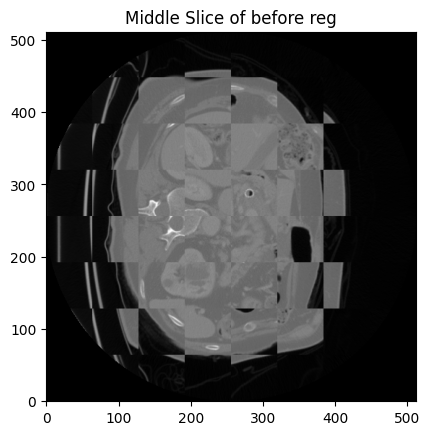

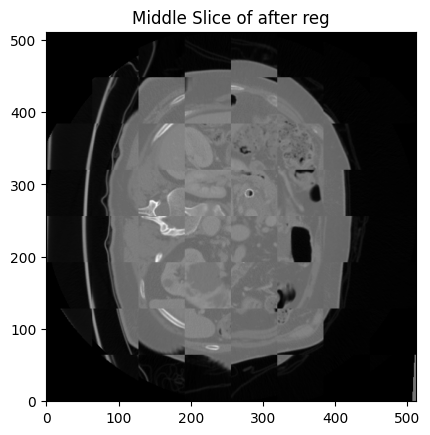

In [5]:
comp_equalized = compare_images(fixed_image[:,:,50], moving_image[:,:,50], method='checkerboard')
plt.imshow(comp_equalized, cmap="gray", origin="lower")
plt.title(f"Middle Slice of before reg")
plt.show()

comp_equalized = compare_images(fixed_image[:,:,50], resampled_moving[:,:,50], method='checkerboard')
plt.imshow(comp_equalized, cmap="gray", origin="lower")
plt.title(f"Middle Slice of after reg")
plt.show()



In [6]:
print(time.time() - start)

22.71065354347229
